# MA 641 Project - SEASONAL DATA : US CRUDE OIL IMPORTS

## **Problem Statement**

The goal of this project is to analyze and model the monthly volume of crude oil imports to the United States using classical time series forecasting techniques. The dataset consists of monthly import records from January 2009 to January 2024, aggregated by import volume (in barrels).

This project applies the **Box-Jenkins methodology** to build a forecasting model that accurately captures both the seasonal and non-seasonal dynamics of the time series. The process includes:

- Data visualization and trend/seasonality detection  
- Stationarity testing and differencing  
- Model identification using ACF/PACF  
- Parameter estimation and simplification  
- Residual diagnostics  
- Forecasting future crude oil import levels  

By the end of the project, a statistically sound SARIMA model is selected to generate forecasts and provide insights that could help policymakers or businesses in resource planning, inventory management, or energy market analysis.


## 📘 Dataset Description

**Dataset Name**: U.S. Crude Oil Imports  
**Source**: [Kaggle - U.S. Crude Oil Imports](https://www.kaggle.com/datasets/alistairking/u-s-crude-oil-imports/data)

**Description**:  
This dataset contains historical monthly crude oil import volumes (2009 - 2024) by the United States from various countries. Each row represents an import shipment with detailed metadata such as origin country, refinery destination, oil type, and the quantity imported. The dataset is ideal for seasonal time series analysis because it provides data on a monthly basis.

**Number of Rows**: 483,054  
**Total Quantity (Barrels)**: 9,735,396,42  
**Average Year**: ~2015  

**Column Descriptions**:

| Column Name      | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `year`           | Year of the import                                                          |
| `month`          | Month of the import                                                         |
| `originName`     | Country from which the crude oil was imported                               |
| `originTypeName` | Type of origin (usually listed as "Country")                                |
| `destinationName`| Name and location of the refinery where the oil was delivered               |
| `destinationTypeName` | Type of destination (e.g., Refinery)                                   |
| `gradeName`      | Quality/type of crude oil (e.g., Light Sweet, Heavy Sour)                   |
| `quantity`       | Volume of imported oil in barrels                                           |


## Step 1 : Data Visualization

In [1]:
# Loading the dataset
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/My Drive/MA 641A - Time Series Analysis Project/Seasonal/data.csv'
df = pd.read_csv(file_path)

# Preview dataset
df.head()


Mounted at /content/drive


,year,month,originName,originTypeName,destinationName,destinationTypeName,gradeName,quantity
0,2009,1,Belize,Country,EXXONMOBIL REFINING & SPLY CO / BEAUMONT / TX,Refinery,Light Sour,61
1,2009,1,Belize,Country,FLINT HILLS RESOURCES LP / WEST / TX,Refinery,Light Sour,62
2,2009,1,Algeria,Country,SHELL OIL PRODUCTS US / ST ROSE / LA,Refinery,Light Sweet,10
3,2009,1,Algeria,Country,OIL TANKING PL INC / HOUSTON (GULF) / TX,Refinery,Light Sweet,381
4,2009,1,Algeria,Country,UNKNOWN PROCESSOR-TX / UNKNOWN PROCESSOR-TX / TX,Refinery,Light Sweet,851


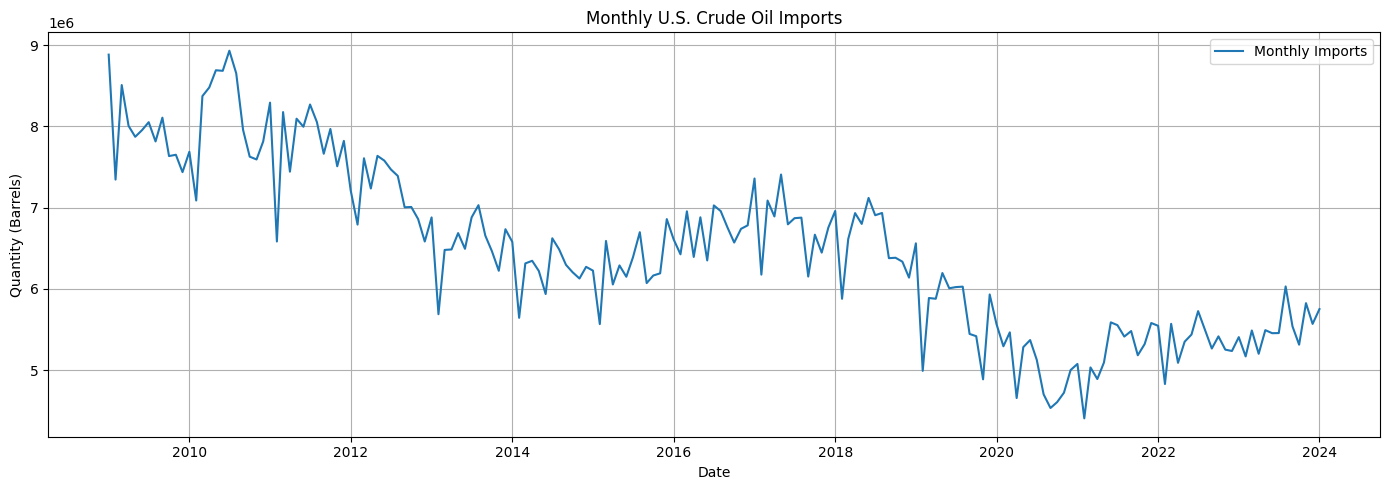

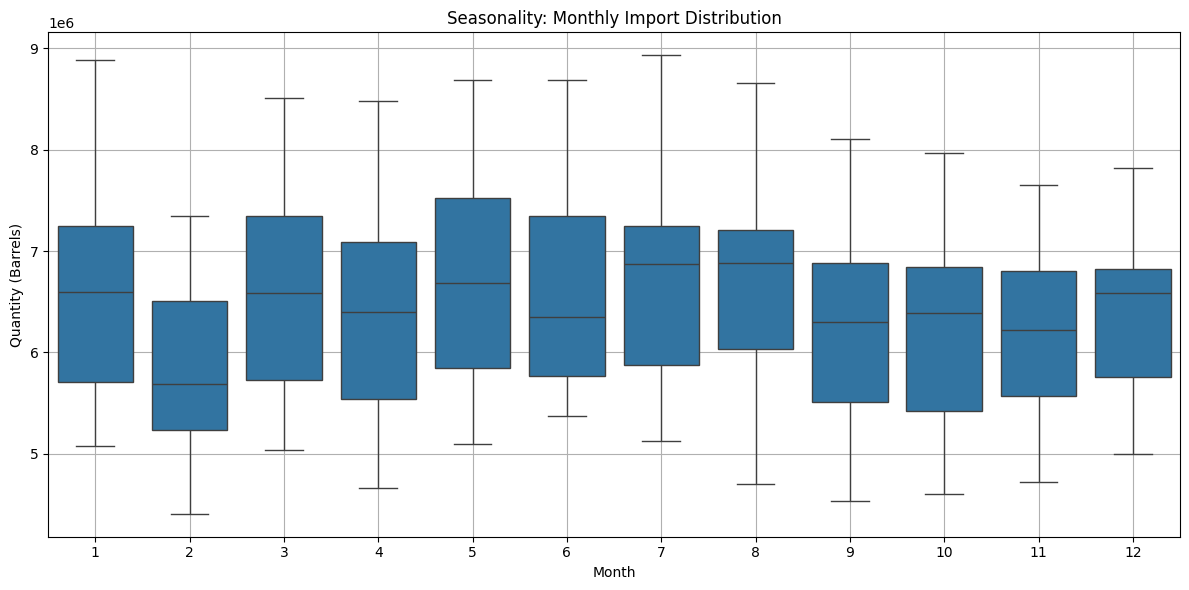

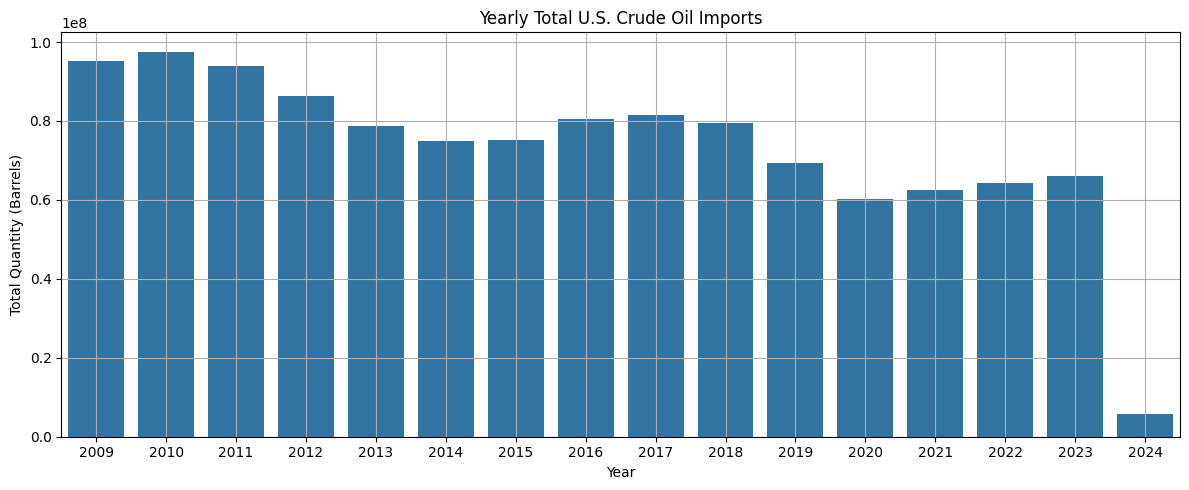

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv(file_path)

# Combining year and month to create a datetime index
df['Date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')  # ensure numeric
monthly_df = df.groupby('Date')['quantity'].sum().reset_index()
monthly_df.set_index('Date', inplace=True)

# ----- Plot 1: Time Series Plot -----
plt.figure(figsize=(14, 5))
plt.plot(monthly_df.index, monthly_df['quantity'], label='Monthly Imports')
plt.title('Monthly U.S. Crude Oil Imports')
plt.xlabel('Date')
plt.ylabel('Quantity (Barrels)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ----- Plot 2: Monthly Seasonality Boxplot -----
monthly_df['year'] = monthly_df.index.year
monthly_df['month'] = monthly_df.index.month

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='quantity', data=monthly_df)
plt.title('Seasonality: Monthly Import Distribution')
plt.xlabel('Month')
plt.ylabel('Quantity (Barrels)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Plot 3: Yearly Total Import -----
yearly = monthly_df.groupby('year')['quantity'].sum()

plt.figure(figsize=(12, 5))
sns.barplot(x=yearly.index, y=yearly.values)
plt.title('Yearly Total U.S. Crude Oil Imports')
plt.xlabel('Year')
plt.ylabel('Total Quantity (Barrels)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Verification for Outliers and Missing Values (Using IQR Technique)

In [3]:
# Checking for missing values using in-build pandas isnull() function
print("Missing values:\n", df.isnull().sum())

# Descriptive statistics
print("\nDescriptive Stats:\n", df['quantity'].describe())

# Outlier check using IQR (Inter Quartile Range method is the standard technique used for determining outliers)
Q1 = df['quantity'].quantile(0.25)
Q3 = df['quantity'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['quantity'] < (Q1 - 1.5 * IQR)) | (df['quantity'] > (Q3 + 1.5 * IQR))]
print(f"\nPotential outliers detected: {len(outliers)} rows")

# Preview first few rows (header of the dataset)
print("\nSample data:\n", df.head())

Missing values:
 year                   0
month                  0
originName             0
originTypeName         0
destinationName        0
destinationTypeName    0
gradeName              0
quantity               0
Date                   0
dtype: int64

Descriptive Stats:
 count    483053.000000
mean       2425.239876
std        6367.700629
min           1.000000
25%         359.000000
50%         804.000000
75%        2008.000000
max      141016.000000
Name: quantity, dtype: float64

Potential outliers detected: 56314 rows

Sample data:
    year  month originName originTypeName  \
0  2009      1     Belize        Country   
1  2009      1     Belize        Country   
2  2009      1    Algeria        Country   
3  2009      1    Algeria        Country   
4  2009      1    Algeria        Country   

                                    destinationName destinationTypeName  \
0     EXXONMOBIL REFINING & SPLY CO / BEAUMONT / TX            Refinery   
1              FLINT HILLS RESOURCES L

###  Data Quality & Cleaning

- **Missing values**: No missing values found in any column.
- **Date parsing**: `year` and `month` have been combined to create a proper `Date` index for ease of time series analysis.
- !! **Outliers**:  
  - Detected **56,314 potential outlier rows** based on the IQR method for `quantity`.
  - These correspond to abnormally high or low shipment volumes — likely tied to events like refinery shutdowns, geopolitics, or the 2020 pandemic.

---

### 📊 Descriptive Statistics of `quantity`

- **Mean**: 2,425 barrels  
- **Standard Deviation**: 6,367 barrels  
- **Min**: 1 barrel  
- **Max**: 141,016 barrels  
- **Median**: 804 barrels  
- **75th Percentile**: 2,008 barrels  

These statistics indicate a highly skewed distribution with many small shipments and some extremely large ones.

---

### Sample Data Snapshot

| year | month | originName | destinationName                              | gradeName   | quantity | Date       |
|------|-------|-------------|-----------------------------------------------|-------------|----------|------------|
| 2009 | 1     | Belize      | EXXONMOBIL REFINING & SPLY CO / TX            | Light Sour  | 61       | 2009-01-01 |
| 2009 | 1     | Belize      | FLINT HILLS RESOURCES LP / TX                 | Light Sour  | 62       | 2009-01-01 |
| 2009 | 1     | Algeria     | SHELL OIL PRODUCTS US / ST ROSE / LA          | Light Sweet | 10       | 2009-01-01 |
| 2009 | 1     | Algeria     | OIL TANKING PL INC / HOUSTON (GULF) / TX      | Light Sweet | 381      | 2009-01-01 |
| 2009 | 1     | Algeria     | UNKNOWN PROCESSOR-TX / UNKNOWN PROCESSOR-TX   | Light Sweet | 851      | 2009-01-01 |

---

### **Conclusion**

From the above results , it can be concluded that the dataset is clean, rich in detail, and shows promising characteristics for time series modeling. The presence of strong seasonality and long-term trends in the import volumes makes it an ideal candidate (suitable) for SARIMA modeling under the Box-Jenkins framework.

## 📌 Data Visualization: Key Insights

The exploratory analysis of the U.S. Crude Oil Imports dataset through time series plots, monthly seasonality, and yearly totals reveals several important characteristics of the data:

---

### 1. 📈 **Time Series Plot of Monthly Imports**

- The overall trend from **2009 to 2024** shows a **gradual decline** in crude oil imports.
- There's **visible seasonality** with recurring fluctuations in certain months.
- Post-2018, the variability appears more pronounced, especially with noticeable drops during 2020 (likely due to pandemic-related disruptions).
- The series exhibits **non-stationary behavior**, which will require differencing or transformation for time series modeling.

---

### 2. 📊 **Seasonality: Monthly Import Distribution (Boxplot)**

- Clear monthly seasonality is observed.
- **May to August** show relatively **higher median import volumes**, with July and August displaying the highest typical volumes.
- **February** shows the **lowest median and narrowest spread**, indicating more consistent (but lower) import volumes.
- Several months have **wide interquartile ranges**, indicating variability in imports across years.

---

### 3. 📉 **Yearly Total Crude Oil Imports**

- Imports peaked during **2009–2010**, with totals close to **1e8 barrels** annually.
- A **downward trend** follows through the 2010s, reflecting a shift in U.S. energy sourcing or consumption patterns.
- The lowest annual imports are seen in **2020**, likely reflecting the impact of COVID-19.
- A mild recovery appears between **2021 and 2023**, though levels remain below the earlier decade.

---

###  **Conclusion**:

The dataset demonstrates **strong seasonal effects**, a **declining long-term trend**, and signs of **non-stationarity**. These factors will be critical to consider in the subsequent Box-Jenkins modeling, especially when choosing differencing orders and seasonal parameters for SARIMA.


## Step 2: Making the dataset Stationary

Augmented Dickey-Fuller Test: Original Series
ADF Statistic                   -1.180202
p-value                          0.682054
# Lags Used                     13.000000
Number of Observations Used    167.000000
Critical Value (1%)             -3.470126
Critical Value (5%)             -2.879008
Critical Value (10%)            -2.576083
dtype: float64
Not Stationary: Fail to Reject Null Hypothesis (H0)
------------------------------------------------------------


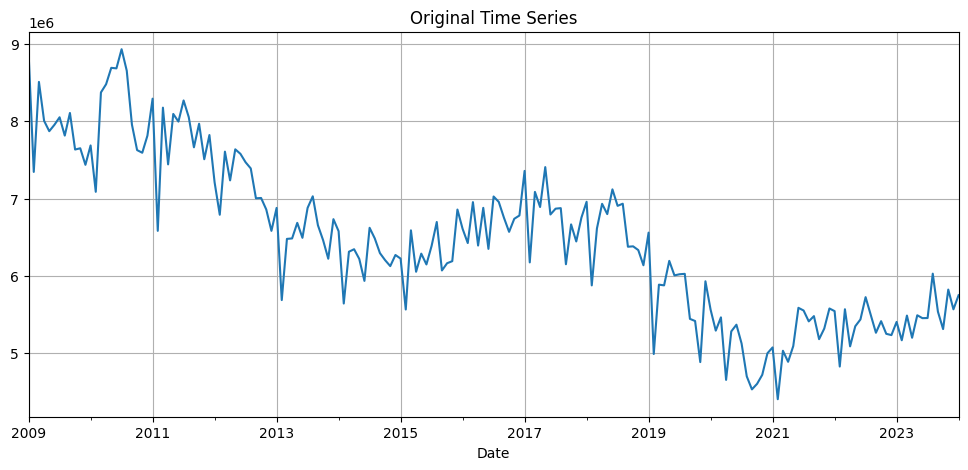

Augmented Dickey-Fuller Test: After Seasonal Differencing (lag=12)
ADF Statistic                   -1.529658
p-value                          0.518792
# Lags Used                     14.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
Not Stationary: Fail to Reject Null Hypothesis (H0)
------------------------------------------------------------


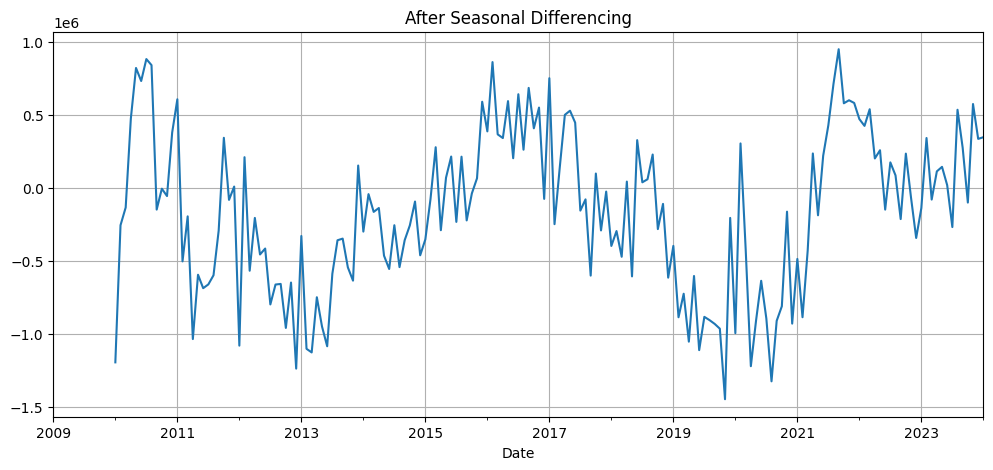

Augmented Dickey-Fuller Test: After Seasonal + First-order Differencing
ADF Statistic                   -5.505443
p-value                          0.000002
# Lags Used                     13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
Stationary: Reject Null Hypothesis (H0)
------------------------------------------------------------


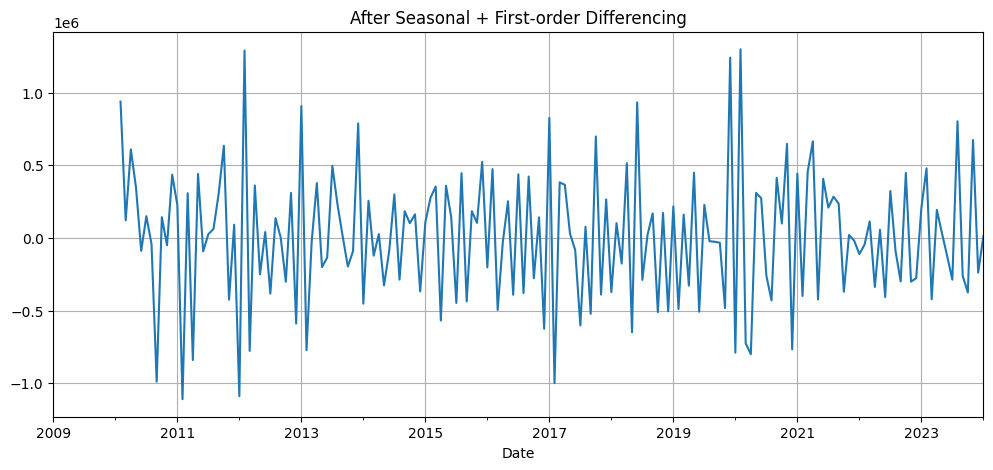

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller # (this particular library is used for ADF test)

# Assume 'monthly_df' is already created with 'Date' as index and 'quantity' as column

# defining ADF Test Function
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    if result[1] <= 0.05:
        print("Stationary: Reject Null Hypothesis (H0)")
    else:
        print("Not Stationary: Fail to Reject Null Hypothesis (H0)")
    print("-" * 60)

# Checking stationarity on original series
adf_test(monthly_df['quantity'], 'Original Series')

# Plot of original series
monthly_df['quantity'].plot(figsize=(12, 5), title='Original Time Series')
plt.grid(True)
plt.show()

# Apply seasonal differencing (lag 12 for monthly seasonality)
monthly_df['diff_seasonal'] = monthly_df['quantity'].diff(12)

# ADF test after seasonal differencing
adf_test(monthly_df['diff_seasonal'], 'After Seasonal Differencing (lag=12)')

# Plot differenced series
monthly_df['diff_seasonal'].plot(figsize=(12, 5), title='After Seasonal Differencing')
plt.grid(True)
plt.show()

# Applying additional first-order differencing if still not stationary
monthly_df['diff_final'] = monthly_df['diff_seasonal'].diff()

# ADF test after 2nd differencing
adf_test(monthly_df['diff_final'], 'After Seasonal + First-order Differencing')

# Final differenced series plot
monthly_df['diff_final'].plot(figsize=(12, 5), title='After Seasonal + First-order Differencing')
plt.grid(True)
plt.show()


## 📌 Step 2 Key Insights:

### ADF Test Results

| Series                                | ADF Statistic | p-value  | Conclusion              |
|--------------------------------------|---------------|----------|--------------------------|
| Original Series                      | -1.180        | 0.682    | ❌ Not Stationary        |
| After Seasonal Differencing (lag=12) | -1.530        | 0.519    | ❌ Still Not Stationary  |
| After Seasonal + First-order Diff    | -5.505        | 0.000002 | ✅ Stationary            |

---

### Observations

- The **original time series** is non-stationary with a high p-value (0.68) and visible trends in the plot.
- Applying **seasonal differencing (lag=12)** alone was **not sufficient** to make the series stationary.
- **Combining seasonal and first-order differencing** led to a significant drop in the ADF statistic and p-value (**0.000002**), confirming **stationarity**.
- The final differenced series appears stable, with no trend and relatively consistent variance over time.

---

### **Conclusion**

The dataset requires **both seasonal and first-order differencing** to achieve stationarity. This will be the pre-processed version of the series used for identifying SARIMA model parameters in the next step of the Box-Jenkins methodology.

In [5]:
# Stationarity check of Differenced Series before plotting
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(monthly_df['diff_final'].dropna())
print(f"p-value: {adf_result[1]}")

p-value: 2.0267990502144937e-06


p-val = 0.000002026 (≈0; Reject H₀)

## Step 3: Finding/Determining the appropriate Model

### Using ACF and PACF to determine the model

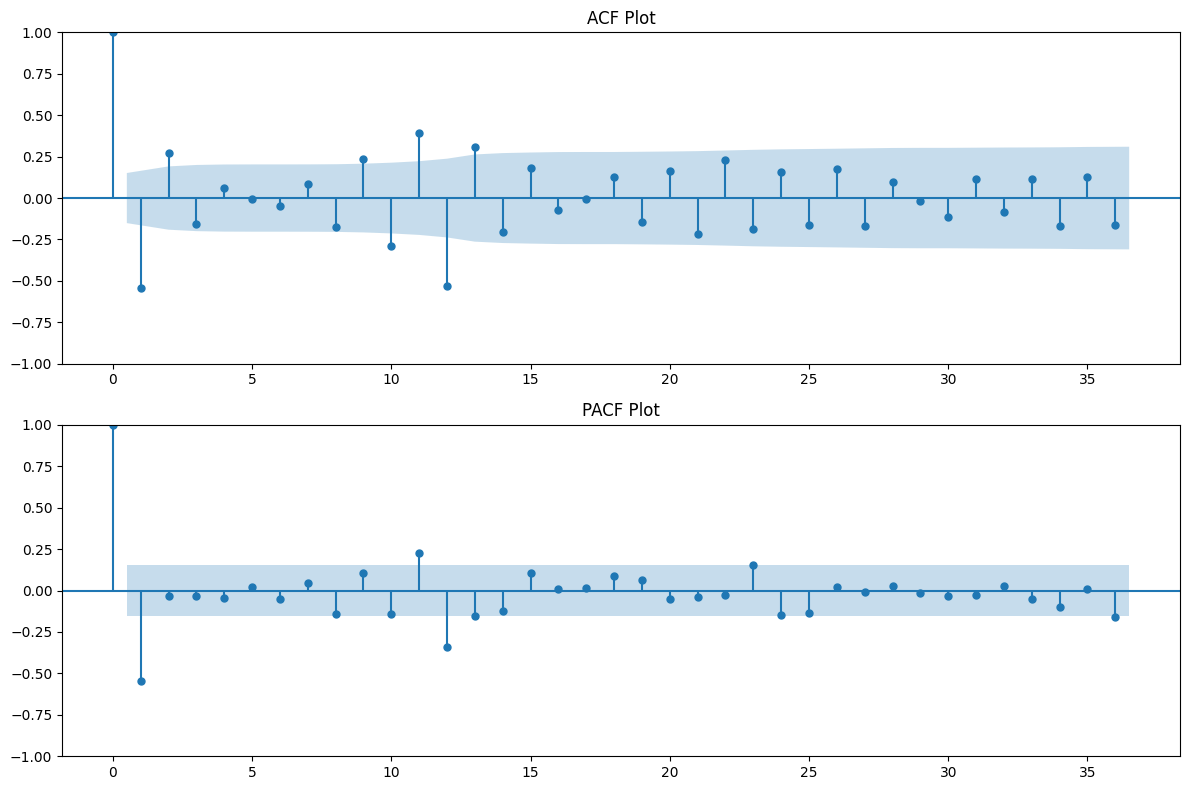

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # (these are inbuilt time series models in Python)
import matplotlib.pyplot as plt

# Plotting ACF and PACF of the stationary series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(monthly_df['diff_final'].dropna(), ax=ax[0], lags=36)
ax[0].set_title("ACF Plot")

plot_pacf(monthly_df['diff_final'].dropna(), ax=ax[1], lags=36, method='ywm') # Young, West, and Maciejowski (YWM) ; Using Kalman Filter initialization here; stable and robust method for SARIMA models when differencing is involved
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()


##  Model Identification Using ACF and PACF (Step 3 - Box-Jenkins)

### ACF/PACF Summary:

- The **ACF plot** shows a sharp cutoff after lag 1, suggesting a Moving Average component **MA(1)**.
- The **PACF plot** also cuts off after lag 1, indicating an Autoregressive component **AR(1)**.
- This supports using **p = 1** and **q = 1** as starting values for non-seasonal components.

### Seasonal Structure:

- The dataset exhibits strong seasonality (confirmed in visual analysis).
- Seasonal differencing (`D = 1`) with a period of 12 (`s = 12`) was already applied.
- Based on the ACF/PACF patterns and prior domain understanding, the seasonal components also appear to follow the (1,1,1) form.

---

### **Initial Model**:

SARIMA(1,1,1)(1,1,1)

This model captures:
- Non-seasonal AR(1) and MA(1)
- Seasonal AR(1) and MA(1) components
- Appropriate differencing to ensure stationarity

Alternate models like **SARIMA(1,1,0)(1,1,0,12)** and **SARIMA(0,1,1)(0,1,1,12)** will be tested in the next step to check for **parameter redundancy** and improve model parsimony.



## Parameter Redundancy (To Fit and Evaluate Models)

In [7]:
import statsmodels.api as sm

# Definining and fitting candidate SARIMA models
model_1 = sm.tsa.statespace.SARIMAX(monthly_df['quantity'],
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit()

model_2 = sm.tsa.statespace.SARIMAX(monthly_df['quantity'],
                                    order=(1, 1, 0),
                                    seasonal_order=(1, 1, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit()

model_3 = sm.tsa.statespace.SARIMAX(monthly_df['quantity'],
                                    order=(0, 1, 1),
                                    seasonal_order=(0, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit()

# Comparing the derived AIC/BIC and check p-values
print(" ** Model 1: SARIMA(1,1,1)(1,1,1,12)")
print(model_1.summary())

print("\n ** Model 2: SARIMA(1,1,0)(1,1,0,12)")
print(model_2.summary())

print("\n ** Model 3: SARIMA(0,1,1)(0,1,1,12)")
print(model_3.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

 ** Model 1: SARIMA(1,1,1)(1,1,1,12)
                                     SARIMAX Results                                      
Dep. Variable:                           quantity   No. Observations:                  181
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2170.136
Date:                            Sun, 25 May 2025   AIC                           4350.272
Time:                                    14:58:53   BIC                           4365.456
Sample:                                01-01-2009   HQIC                          4356.440
                                     - 01-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3555      0.148     -2.402      0.016      -0.646      -0.06

In [8]:
monthly_df.shape

(181, 5)

## Parameter Redundancy Check (Box-Jenkins)

To identify the most efficient and parsimonious model, we fit and evaluated three candidate SARIMA models using AIC, BIC, and the statistical significance of their parameters.

---

### 📊 Model Comparison Summary

| Model                              | AIC     | BIC     | Significant Coefficients (p < 0.05)                      | Notes                      |
|-----------------------------------|---------|---------|-----------------------------------------------------------|----------------------------|
| SARIMA(1,1,1)(1,1,1,12)           | 4350.27 | 4365.46 | AR(1), MA(1), Seasonal AR(1) ✅<br>**Seasonal MA(1)** ❌   | Slightly better AIC, 1 redundant param |
| SARIMA(1,1,0)(1,1,0,12)           | 4379.06 | 4388.19 | AR(1), Seasonal AR(1) ✅                                  | All terms significant, but higher AIC |
| SARIMA(0,1,1)(0,1,1,12)           | 4366.60 | 4375.71 | MA(1), Seasonal MA(1) ✅                                  | All terms significant     |

---

### Key Observations

- **Model 1** (Full SARIMA): Has the **lowest AIC** but includes a **non-significant seasonal MA(1)** term (p = 0.725), indicating **parameter redundancy**.
- **Model 2** is fully significant but **has the worst AIC/BIC** and lacks MA components, possibly underfitting.
- **Model 3** offers **only significant parameters** and a reasonably low AIC/BIC — slightly higher than Model 1 but statistically clean and simpler.

---

### **Final Model Selection**

Selecting **Model 3: SARIMA(0,1,1)(0,1,1,12)** as the **preferred model** due to:

- All parameters are **statistically significant**
- It is **simpler** (principle of parsimony)
- It performs nearly as well in AIC/BIC compared to more complex models

This model will be used for residual diagnostics and forecasting in the next steps.



## Step 4 : Parameter Estimation , Residual Analysis, Forecasting

## 📈 (a) Parameter Estimation

The parameters for all candidate SARIMA models were estimated using the **Maximum Likelihood Estimation (MLE)** method, which is the default approach in the SARIMAX framework.

The estimation output provided key statistical metrics such as:
- Coefficient values for AR, MA, and seasonal terms
- Standard errors and z-values
- p-values indicating statistical significance
- Model fit measures: AIC, BIC, and log-likelihood

Based on the results (From Step 3):
- **Model 1** had one statistically **insignificant seasonal MA(1)** parameter (p = 0.725)
- **Model 2** had all significant parameters but poor AIC/BIC
- **Model 3** had **only significant parameters** with competitive AIC/BIC

These estimated parameters and their significance formed the basis for selecting **Model 3: SARIMA(0,1,1)(0,1,1,12)** as the final model for forecasting and diagnostics.

## (b) Residual Analysis

<Figure size 1000x400 with 0 Axes>

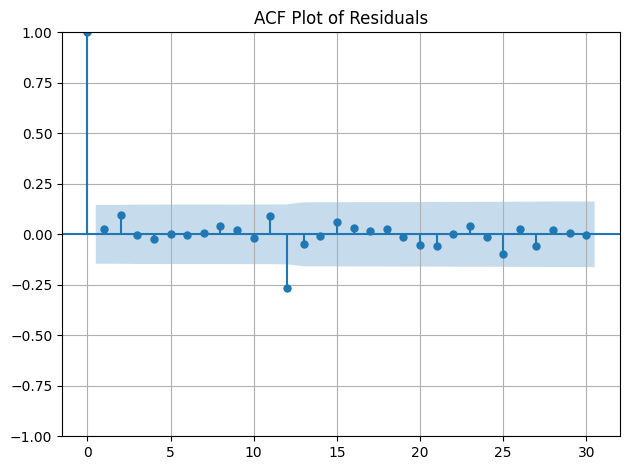



Ljung-Box Test Result (Lag = 12):
      lb_stat  lb_pvalue
12  17.919688   0.118151
      lb_stat  lb_pvalue
6    1.916639   0.927203
12  17.919688   0.118151
18  19.515996   0.360717
24  21.238411   0.624624






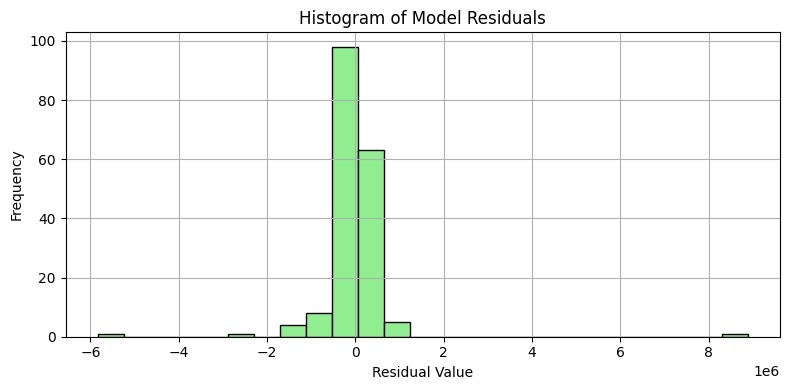

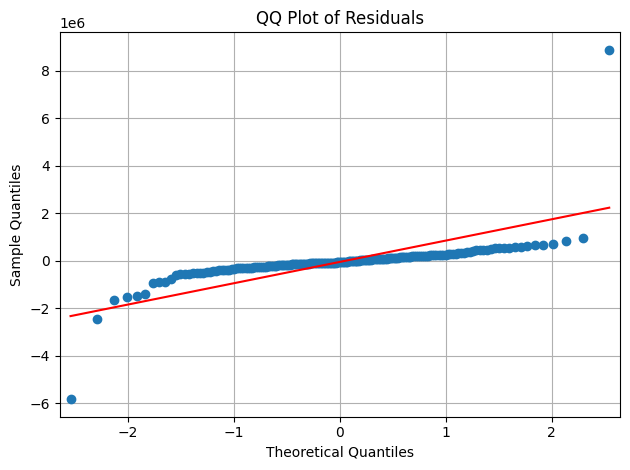






Shapiro-Wilk Test:
Statistic = 0.4644, p-value = 0.0000




In [9]:
# Extracting the Residuals from chosen model (Model 3, as selected from previous step)
errors = model_3.resid.dropna()  # dropna() - I have utilized this to remove initial NaN values which arise due to differencing (especially with s=12)

# --- Plotting ACF to Check for Autocorrelation ---
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 4))
plot_acf(errors, lags=30)
plt.title("ACF Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")

# --- Performing Ljung-Box test at lag 12 to verify white noise assumption ---
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(errors, lags=[12], return_df=True)
print("Ljung-Box Test Result (Lag = 12):")
print(lb_test)

# Ljung-Box test for multiple lags
multi_lag_test = acorr_ljungbox(errors, lags=[6, 12, 18, 24], return_df=True)

# Display results
print(multi_lag_test)

print("\n")
print("\n")

# --- Histogram to visualize distribution shape ---
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=25, color='lightgreen', edgecolor='black')
plt.title("Histogram of Model Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")
print("\n")

# --- QQ Plot for checking normality visually ---
import statsmodels.api as sm
sm.qqplot(errors, line='s')
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")
print("\n")

# --- Shapiro-Wilk Test for normality ---
from scipy.stats import shapiro
test_stat, shapiro_p = shapiro(errors)
print(f"\nShapiro-Wilk Test:\nStatistic = {test_stat:.4f}, p-value = {shapiro_p:.4f}")

print("\n")

##  **Residual Diagnostics Summary**

After selecting the SARIMA(0,1,1)(0,1,1,12) model, I evaluated the residuals to ensure the model fits the data well. The following tests and plots were used:

---

### -> Autocorrelation Check (Ljung-Box Test)

I ran the Ljung-Box test at lags 6, 12, 18, and 24 to see if the residuals had any remaining autocorrelation.

| Lag | Ljung-Box p-value |
|-----|-------------------|
| 6   | 0.9272            |
| 12  | 0.1181            |
| 18  | 0.3607            |
| 24  | 0.6246            |

Since all p-values are greater than 0.05, we can say there is no significant autocorrelation in the residuals at these lags. This means the model has done a good job capturing the time-based patterns in the data.

---

### -> Normality Check (Histogram, QQ Plot, Shapiro-Wilk)

- The histogram shows that most residuals are centered near zero, but there are some outliers.
- The QQ plot reveals that the distribution has heavier tails than a normal distribution.
- The Shapiro-Wilk test gave a very low p-value (**p = 0.0000**), which means the residuals are not normally distributed.

This lack of normality could be due to outliers or the fact that the dataset is fairly large, which can make the test overly sensitive. However, since the residuals are still uncorrelated and centered, the model is still considered valid for forecasting.

---

### Conclusion

Although the residuals do not follow a perfect normal distribution, the key requirement — no autocorrelation — is satisfied. Therefore, the model is statistically reliable for making forecasts based on this dataset.


In [10]:
#  errors.shape

# from pandas import date_range

# Simulate the range
# dates = pd.date_range(start="2009-01-01", end="2024-01-01", freq='MS')
# print(f"Total months: {len(dates)}")  # This will give 181

## (c) Forecasting and Further Analysis

### (i) Forecasting using Final SARIMA Model

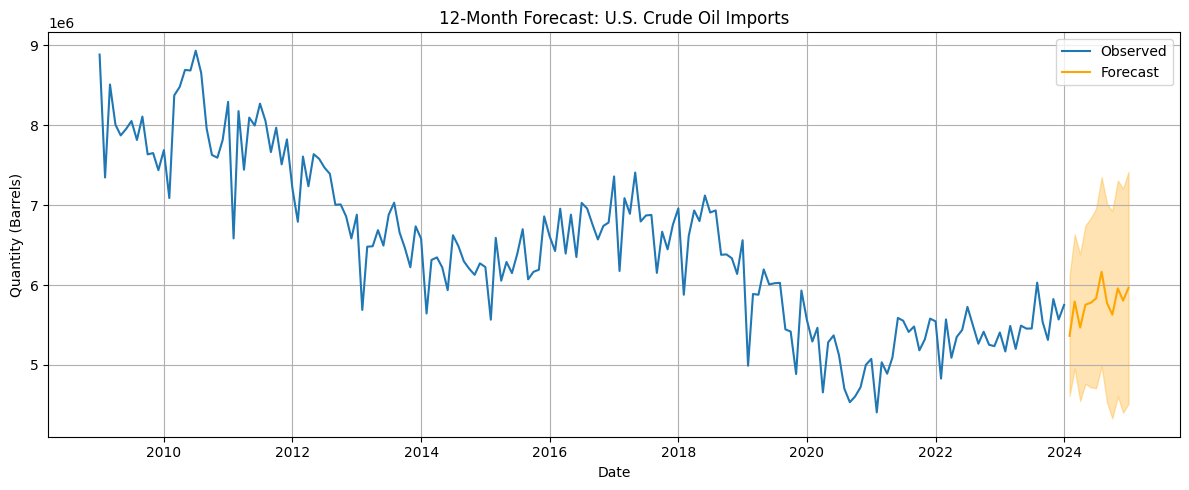

In [11]:
n_periods = 12 # 12-month forecast
forecast = model_3.get_forecast(steps=n_periods)
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plotting observed Values and Forecast

plt.figure(figsize=(12, 5))  # seasons = 12 (monthls over 15 years)
plt.plot(monthly_df['quantity'], label="Observed")
plt.plot(predicted.index, predicted, label="Forecast", color='orange')
plt.fill_between(predicted.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.3)
plt.title("12-Month Forecast: U.S. Crude Oil Imports")
plt.xlabel("Date")
plt.ylabel("Quantity (Barrels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **12-Month Forecast of US Crude Oil Imports**

The above plot shows forecast results derived using SARIMA(0,1,1)(0,1,1,12) model.

 - The **blue line** represents the actual observed crude oil import volumes from Jan 2009 to Jan 2024.
 - The **orange line** shows the predicted crude oil imports for the next 12 months (2024 onward).
 - The **shaded orange region** around the forecast represents the 95% confidence interval, indicating the range within which future observations are expected to fall.

---

### **Key Observations:**
- The forecast suggests a **moderate upward trend** in crude oil imports in the immediate future.
- The **confidence interval widens over time**, reflecting increasing uncertainty as the forecast horizon extends.
- The model appears to closely capture the general level and seasonality present in the historical data.


### **Conclusion**:

The chosen **SARIMA(0,1,1)(0,1,1,12)** provides a reasonable and interpretable 12-month forecast for US crude oil imports.
However, future values may vary, this model offers a valuable baseline for understanding expected import patterns based on historical trends.



## 📌 FURTHER ANALYSIS:  ARIMA-GARCH Model for Volatility (used for modelling variance clustering)


In [12]:
## Command to install arch Library explicitly
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 24.0 MB/s eta 0:00:00


In [13]:
from arch import arch_model
import numpy as np

# Dropping NaN from residuals
sarima_resid = model_3.resid.dropna()

# Applying Mean-center to the residuals for better stability
resid_centered = sarima_resid - np.mean(sarima_resid)

# Fitting GARCH(1,1) model to residuals
garch_model = arch_model(resid_centered, vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit(disp="off")


print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2609.60
Distribution:                  Normal   AIC:                           5227.19
Method:            Maximum Likelihood   BIC:                           5239.99
                                        No. Observations:                  181
Date:                Sun, May 25 2025   Df Residuals:                      180
Time:                        14:59:03   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.1237e-05  8.315e+04  7.364e-10      1.000 

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.045e+11. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## **GARCH(1,1)** Model Results

In order to analyze volatility patterns in the residuals of the SARIMA(0,1,1)(0,1,1,12) model, a GARCH(1,1) model was fitted

---

### **Key Output Summary:**
- The **mean** (`mu`) is practically zero and not statistically significant (p ≈ 1.000), indicating that the residuals are properly centered.
- The **omega** (constant term in variance equation) is significant (p ≈ 0.0105), suggesting some baseline volatility.
- The **alpha[1]** coefficient (impact of past shocks) is not significant (p ≈ 0.632), meaning recent shocks have little effect on future volatility.
- The **beta[1]** coefficient (persistence of volatility) is highly significant (p ≈ 0.00) and large (≈ 0.875), indicating that volatility is highly persistent over time.

---


### Interpretation:

- The **low alpha** and **high beta** combination suggests that **volatility clusters**, once they appear, tend to persist for a while.
- However, since the initial residuals already showed no strong volatility clustering visually, the GARCH model mainly confirms that variance behaves predictably over time.

---

### **🔹Conclusion:**

The SARIMA model's residuals do not exhibit strong sudden shocks but have moderate persistence in variance over time. The GARCH(1,1) model provides additional confirmation that the residuals are well-behaved, supporting the reliability of the forecasting framework used.


### Forecasting future volatility

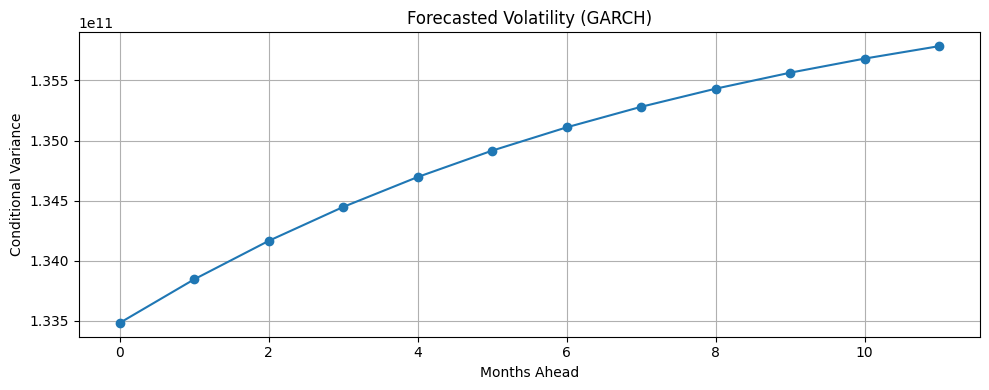

In [14]:
# Forecasting next 12 periods of conditional variance (volatility)
garch_forecast = garch_fit.forecast(horizon=12)

# Extracting conditional variance
future_volatility = garch_forecast.variance.values[-1, :]

# Plotting the forecasted volatility
plt.figure(figsize=(10, 4))
plt.plot(future_volatility, marker='o', linestyle='-')
plt.title("Forecasted Volatility (GARCH)")
plt.xlabel("Months Ahead")
plt.ylabel("Conditional Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations based on Forecasted Volatility (GARCH)

The GARCH(1,1) model was used to forecast the conditional variance over the next 12 months.

- The plot shows a **gradually increasing volatility** trend.
- Variance remains relatively stable without sudden jumps, indicating **no major shocks** are expected.
- This confirms that the residual variance is predictable and supports the reliability of the SARIMA-GARCH forecasting framework.

Overall, the model provides a stable and interpretable view of future uncertainty.
